In [10]:
import os
import boto3
# import pyart
import numpy as np
import matplotlib.pyplot as plt

from botocore import UNSIGNED
from botocore.client import Config
from datetime import datetime, timedelta

from functools import partial
from multiprocessing import Pool, cpu_count

In [47]:
def s3_list_files(bucket_name, prefix):
    
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    paginator = client.get_paginator("list_objects")

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    keys = []
    for page in page_iterator:
        if "Contents" in page:
            for key in page["Contents"]:
                keyString = key["Key"]
                keys.append(keyString)

    return keys if keys else []

def s3_to_temp(object_name, bucket_name, tmp):
    
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    
    file_dir = tmp + '/' + '/'.join(object_name.split('/')[:-1])
    os.makedirs(file_dir, exist_ok=True)

    f = object_name.split('/')[-1]
    client.download_file(bucket_name, object_name, file_dir + '/' + f)
    
    return file_dir + '/' + f

In [48]:
user = 'u1070830'

temp_dir = '/scratch/general/lustre/%s/radar/'%user
os.makedirs(temp_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket = 'noaa-nexrad-level2'

In [49]:
site = 'KMTX'
get_hour = datetime(2002, 12, 15, 12)

In [50]:
obj_list = [f for f in s3_list_files(bucket, 
                                     prefix='%04d/%02d/%02d/%s'%(
                                         get_hour.year, get_hour.month, get_hour.day, site),) 
            if '.tar' not in f]

get_these_hours = np.arange(9, 18+1, 1)
obj_list = [f for f in obj_list if int(f.split('_')[-1][:2]) in get_these_hours]

In [51]:
s3_to_temp_mp = partial(s3_to_temp, bucket_name=bucket, tmp=temp_dir)

with Pool(cpu_count()-1) as p:
    filelist = p.map(s3_to_temp_mp, obj_list)
    p.close()
    p.join()
    
filelist = np.array(sorted(filelist))

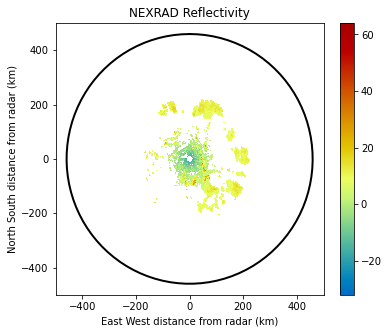

In [52]:
f = filelist[0]

radar = pyart.io.read_nexrad_archive(f)
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',
             vmin=-32, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)

plt.show()

In [55]:
for f in filelist:
    try:
        os.remove(f)
    except:
        print(f, 'does not exist')
    else:
        print(f, 'deleted')

/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_090003.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_090550.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_091138.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_091725.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_092313.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_092901.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_093448.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_093726.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_093901.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX20021215_094035.gz does not exist
/scratch/general/lustre/u1070830/radar//2002/12/15/KMTX/KMTX